** Image segmentation test using OpenCV and the watershed algorithm**

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt


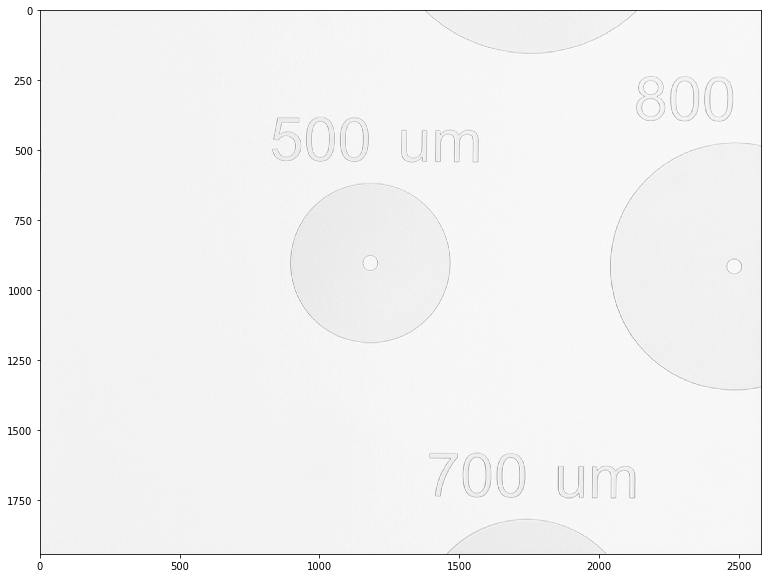

In [2]:
# Import image
img = cv2.imread('images/500um_2.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(15,10))
plt.imshow(gray, cmap='gray',vmin=0, vmax=255)

In [3]:
def adjust_brighness_contrast(img, brightness=0, contrast=1, first='contrast'):
    out = img
    assert len(img.shape) >1
    if len(img.shape)>2:
        assert img.shape[2]==1
        out = img.reshape(img.shape[0:2])
    
    if first=='contrast':
        out = np.clip(contrast*out + brightness,0,255).astype(np.uint8)
    elif first=='brightness':
        out = np.clip(contrast*(out + brightness),0,255).astype(np.uint8)
    else:
        out = None
        raise ValueError("First argument must be either 'contrast' or 'brightness'")
    return out

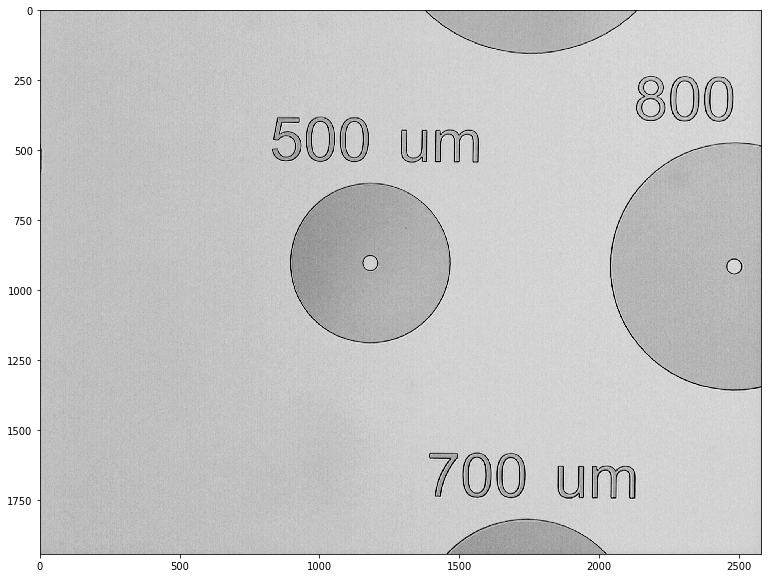

In [4]:
gray_contr = adjust_brighness_contrast(gray,brightness=-200, contrast=4.5, first='brightness')
plt.figure(figsize=(15,10))
plt.imshow(gray_contr, cmap='gray',vmin=0, vmax=255)

** Flood fill **

In [7]:
ret, gray_flood = cv2.floodFill(gray_contr, None, (10,10) , 0)
plt.figure(figsize=(15,10))
plt.imshow(gray_flood, cmap='gray', vmin=0, vmax=255)

ValueError: too many values to unpack (expected 2)

In [ ]:
gray_dumb = gray
gray_dumb[gray_dumb < gray[10,1500]] = gray[10,1500]

plt.figure(figsize=(15,10))
plt.imshow(gray_dumb, cmap='gray', vmin=0, vmax=255)

** KMeans clustering

In [ ]:
Z = adjust_brighness_contrast(gray,brightness=-240, contrast=4.5, first='brightness').reshape((-1,1))

# convert to np.float32
Z = np.float32(Z)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Now convert back into uint8, and make original image
center = np.uint8(center)
center[label.flatten()[10]] = 0
center[center != 0] = 255
gray_kmeans = center[label.flatten()]
gray_kmeans = gray_kmeans.reshape((gray.shape))

plt.figure(figsize=(15,10))
plt.imshow(gray_kmeans, cmap='gray', vmin=245, vmax=255)

In [ ]:
gray_adj.min()

** Detecting etched regions **

Otsu thresholding:

In [ ]:
# Thresholding
gray_adj = adjust_brighness_contrast(gray,brightness=-200, contrast=3, first='brightness')
ret, thresh = cv2.threshold(gray_adj,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.figure
plt.hist(gray.ravel(),256)
plt.title("Intensity histogram")
plt.figure(figsize=(20,13))
plt.imshow(thresh, cmap='gray')
plt.title("Otsu algorithm")
plt.show()

** Adaptive thresholding **

Filtering and edge detection 

In [ ]:
# Filter
f_kernel_sharp = np.array([[0,-1,0],
                            [-1,5,-1],
                            [0, -1, 0]])
f_kernel_blurr = 1/16*np.array([[1,2,1],
                                [2,4,2],
                                [1,2,1]])
identity = np.array([[0,0,0],
                    [0,1,0],
                    [0,0,0]])
gray_f = cv2.filter2D(gray, -1, f_kernel_blurr)
#gray_f = cv2.filter2D(gray_f, -1, f_kernel_sharp)

plt.figure(figsize=(20,13))
plt.title("Grayscale filtered")
plt.imshow(gray_f, cmap='gray')

# Edge detection
edges = cv2.Canny(gray_f, 150, 250, apertureSize=5)

plt.figure(figsize=(20,13))
plt.imshow(edges, cmap='gray')
plt.show()

edge_row, edge_col = np.where(edges == 255)
gray_edges = gray
gray_edges[edge_row, edge_col] = 0
print(gray[1000,2400])
plt.figure(figsize=(20,13))
plt.imshow(gray_edges, cmap='gray')
plt.title("Recolored edges")

# 2nd pass with otsu algorithm
ret3, thresh3 = cv2.threshold(gray_edges,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.figure(figsize=(20,13))
plt.imshow(thresh3, cmap='gray')

In [ ]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(th3,cv2.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
plt.imshow(unknown, cmap='gray')

In [ ]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0
plt.imshow(unknown, cmap='gray')

In [ ]:
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

In [ ]:
plt.imshow(img,cmap='gray')